# Logistic Regression and Classification

In [1]:
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import chi2
import sympy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

Logistic regression: predicts probability of an outcome given 1+ variables

Logistic regression is:
- trained on a discrete output variable (boolean or integer)
- resilient against outliers and other data challenges
- outputs a continuous value which can be convertd into a discrete value
- results in a curve indicating probability of an outcome

Classification: predicting categories <br>
logistic regression can be used for classification tasks by assigning a threshold to the logistic regression to predict belonging to a category (a probability below the threshold is classified as 0, above classified as 1)

A logistic regression uses the logistic function

Logistic function: sigmoid curve that produces an output between 0 and 1, for 1+ variables

The logistic function for outputting a probability $y$ for one input variable $x$:

$ y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} = \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}$

$ \beta_0 + \beta_1 x $ is called a log-odds function

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))


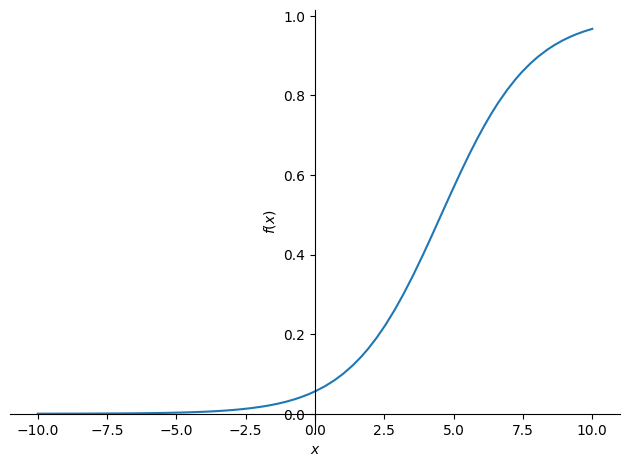

In [2]:
# plot logistic function

# define variables
b0, b1, x = sympy.symbols('b0 b1 x')
# define equation
p = 1.0 / (1.0 + sympy.exp(-(b0 + b1 * x)))
# substitute values
p = p.subs(b0, -2.823)
p = p.subs(b1, 0.620)
# display function
print(p)
sympy.plot(p);

Fitting a model requires an objective function. For logistic regression, that is a *maximum likelihood estimation*.

Maximum likelihood estimation (MLE): function maximizing likelihood that a given logistic curve would output the observed data

In [3]:
# fitting logistic regression from sklearn
url = 'https://bit.ly/33ebs2R'

# load data and extract input and output variables
patient_data = pd.read_csv(url)
X = patient_data.values[:, :-1]
y = patient_data.values[:, -1]

# fit logistic regression
model = LogisticRegression(penalty= None)
model.fit(X, y)

# print coefficients
print(model.coef_.flatten())
print(model.intercept_.flatten())

[0.69267212]
[-3.17576395]


apply gradient descent (GD) or SGD or mini-batch GD to solve MLE

Joint likelihood: likelihood of seeing all data points (or sample) for a given logistic regression curve.

$ \displaystyle\prod_{i=1}^{n} (\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{y_i} * (\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{1-y_i} $, where

$x_i$ is the data point input, and <br>
$y_i$ is the discrete output prediction (as a 1 or 0)

In [4]:
# calculate joint likelihood for fitted data

# get data and model
patient_data_iter = patient_data.itertuples()
b1 = model.coef_.flatten()[0]
b0 = model.intercept_.flatten()[0]

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# calculate joint likelihood
joint_likelihood = 1.0
for p in patient_data_iter:
    if p.y == 1.0:
        joint_likelihood *= logistic_function(p.x)
    elif p.y == 0.0:
        joint_likelihood *= (1.0 - logistic_function(p.x))

print(joint_likelihood)

4.791118022168743e-05


When a lot of mathematical calculation is done with computers, especially with very small numbers such as those from joint likelihood products, it is possible to experience *floating point underflow*.

Floating point underflow: when computer limits on floating point numbers affect numerical accuracy

to solve this problem for joint likelihood, take the log of the decimals, add them together, then raise the number back to the exponent of $e$ to convert back to joint likelihood. This form of calculation is more numerically stable.

joint likelihood = $ \displaystyle\sum_{i=1}^{n} log((\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{y_i} * (\frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}})^{1-y_i}) $

In [5]:
# calculate joint likelihood using logs

joint_likelihood = 0.0
patient_data_iter = patient_data.itertuples()
for p in patient_data_iter:
    joint_likelihood += math.log(
        logistic_function(p.x) ** p.y * \
        (1.0 - logistic_function(p.x)) ** (1.0 - p.y))
joint_likelihood = math.exp(joint_likelihood)
print(joint_likelihood)

4.791118022168748e-05


In [6]:
# use gradient descent for logistic regression

# get data
url = 'https://tinyurl.com/y2cocoo7'
points = list(pd.read_csv(url).itertuples())

# define variables
b1, b0, i, n = sympy.symbols('b1 b0 i n')
x, y = sympy.symbols('x y', cls=sympy.Function)

# calculate joint likelihood
joint_likelihood = sympy.Sum(sympy.log(
    (
        1.0 / \
        (1.0 + sympy.exp(-(b0 + b1 * x(i))))
    ) ** y(i) \
    * \
    (
        1.0 - \
        (
            1.0 / \
            (1.0 + sympy.exp(-(b0 + b1 * x(i))))
        )
    ) ** (1 - y(i))
), (i, 0, n))

# calculate partial derivatives
d_b1 = sympy.diff(joint_likelihood, b1) \
    .subs(n, len(points) - 1).doit() \
    .replace(x, lambda i: points[i].x) \
    .replace(y, lambda i: points[i].y)
d_b0 = sympy.diff(joint_likelihood, b0) \
    .subs(n, len(points) - 1).doit() \
    .replace(x, lambda i: points[i].x) \
    .replace(y, lambda i: points[i].y)
#lambdify for faster computation
d_b1 = sympy.lambdify([b1, b0], d_b1)
d_b0 = sympy.lambdify([b1, b0], d_b0)

# initialize parameters
b1 = 0.01
b0 = 0.01
L = 0.01

# perform gradient descent
for j in range(10_000):
    b1 += d_b1(b1, b0) * L
    b0 += d_b0(b1, b0) * L

print(b1, b0)

0.6926693075370812 -3.175751550409821


**DO NOT MAKE HAPHAZARD PREDICTIONS ON PEOPLE DATA**

seemingly benign variables can correlate with discriminatory variables

A good way to understand inputs is to understand outputs (what are the predictions being used for?)

In [7]:
# odds perspective calculation from logistic regression

hours_of_exposure = 6.0

def logistic_function(b0, b1, x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

p = logistic_function(b0, b1, hours_of_exposure)
print(p)

def odds(p):
    return p / (1-p)

odds_ = odds(p)

print(f'A patient is {round(odds_, 3)} times more likely to show symptoms than not show symptoms after {int(hours_of_exposure)} hours of exposure.')

0.7271606550610753
A patient is 2.665 times more likely to show symptoms than not show symptoms after 6 hours of exposure.


Wrapping the odds function in log yeilds the logit function.

$ log({\frac{p}{1-p}}) $

In [8]:
# get logit
logit = math.log(odds_)
print(logit)

0.9802642948126671


The logit function yields the same answer as the log-odds function.

$ log(\frac{p}{1-p}) = \beta_0 + \beta_1 x $

In [9]:
# get log-odds and show equality to logit
logodds = b0 + b1 * hours_of_exposure
print(logodds)
print(round(logit, 5) == round(logodds, 5))

0.9802642948126667
True


logarithms rescale odds so they are linear, making them easier to compare

odds ratios can compare effects of one x-value to another

$ O_a = \frac{p_a}{1 - p_a} $

$ O_b = \frac{p_b}{1 - p_b} $

odds ratio = $ {O_a \over O_b} $

where $a$ is (odds ratio) times more likely to happen than $b$.

McFadden's Pseudo R-squared: Closely mimics the $R^2$ used in linear regression, but for logistic regression

$ \frac{\text{log likelihood} - \text{log likelihood fit}}{\text{log likelihood}} $, where

log likelihood = $ \frac{\sum y_i}{n} * y_i + (1- \frac{\sum y_i}{n}) * (1-y_i) $, and

log likelihood fit = $ \displaystyle\sum_{i=1}^{n} log(f(x_i))*y_i + log(1 - f(x_i)) * (1-y_i) $, where

$y_i$ is the true output value and

$f(x_i)$ is the logistic function.

There is no concensus on the best way to calculate $R^2$ on a logistic regression.

In [10]:
# calculate R^2 for logistic regression
patient_data = list(patient_data.itertuples())

b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + (math.exp(-(b0 + b1 * x))))
    return p

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(math.log(likelihood) * p.y + math.log(1.0 - likelihood) * (1.0 - p.y) \
                     for p in patient_data)

log_likelihood_fit = sum(math.log(logistic_function(p.x)) * p.y + \
                        math.log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                        for p in patient_data)

r2 = (log_likelihood - log_likelihood_fit) / log_likelihood

print(r2)


0.306456105756576


Like in linear regression, a strong R^2 value does not necessarily indicate an actual relationship. We need a p-value to determine if the relationship is valid.

p-value = $\chi^{2}_{n-1}(2 * \text{log likelihood fit} - \text{log likelihood})$, where

$\chi^{2}_{n-1}$ is the $\chi^2$ distribution with $n-1$ degrees of freedom

In [11]:
# calculate p-value for logistic regression
b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + (math.exp(-(b0 + b1 * x))))
    return p

likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(math.log(likelihood) * p.y + math.log(1.0 - likelihood) * (1.0 - p.y) \
                     for p in patient_data)

log_likelihood_fit = sum(math.log(logistic_function(p.x)) * p.y + \
                        math.log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                        for p in patient_data)

p_value = chi2.pdf((2*(log_likelihood_fit - log_likelihood)), 1)

print(p_value)

0.0016604875618753787


We can also use train/test splits on logistic regression to determine the robustness of our model choice.

In [12]:
# K-fold validation on linear regression

# get input and output variables
df = pd.read_csv("https://tinyurl.com/y6r7qjrp")
X = df.values[:, :-1]
y = df.values[:, -1]

# fit K-folds
kfold = KFold(n_splits=5, random_state=7, shuffle=True)
model = LogisticRegression(penalty=None)
results = cross_val_score(model, X, y, cv=kfold)

print(f'Model Accuracy: Mean = {round(results.mean(), 3)}, StdDev = {round(results.std(), 3)}')

Model Accuracy: Mean = 0.633, StdDev = 0.093


Accuracy is a misleading measure of success for classification. It only captures total true predictions, and cannot account for the importance of Type 1 and Type 2 errors.

Confusion matrix: a grid of results comparing model predictions against actual values

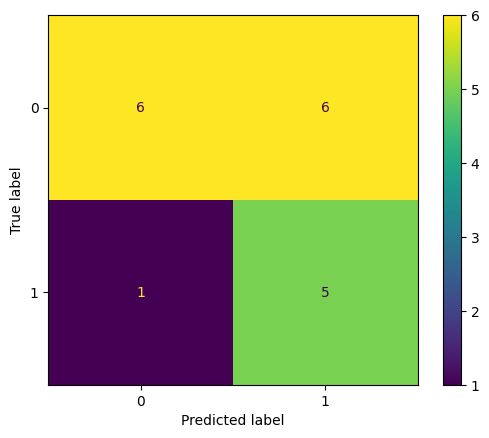

In [13]:
# confusion matrix 
model = LogisticRegression(solver= 'liblinear')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=7)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
matrix = confusion_matrix(y_true= y_test, y_pred= prediction)
ConfusionMatrixDisplay(confusion_matrix= matrix).plot()
plt.show()

The top-left-to-bottom-right-diagonal values in the confusion matrix are the correct values. <br>
The above model over-predicts the true label. Only 50% of the negative true values were correctly classified as negative!

Bayes' theorem can be useful when working with confusion matrices.

In [14]:
# patient data

patient_df = pd.DataFrame(
    data= {
        'tests positive': [198, 50],
        'tests negative': [2, 750]
    },
    index = ['at risk', 'not at risk']
)

display(patient_df)

,tests positive,tests negative
at risk,198,2
not at risk,50,750


In [15]:
# sensitivity and precision
sensitivity = patient_df.loc['at risk', 'tests positive'] / sum(patient_df.loc['at risk', :])
print(sensitivity)
precision = patient_df.loc['at risk', 'tests positive'] / sum(patient_df.loc[:, 'tests positive'])
print(precision)

0.99
0.7983870967741935


$ P(\text{At Risk if Positive}) = \frac{P(\text{Positive if At Risk}) * P(\text{At Risk})}{P(\text{Positive})} $

In [16]:
# using Bayes' theorem to determine risk if positive
p_positive_given_at_risk = patient_df.loc['at risk', 'tests positive'] / sum(patient_df.loc['at risk', :])
p_positive = sum(patient_df.loc[:, 'tests positive']) / patient_df.values.sum()

p_at_risk = 0.01

p_at_risk_given_positive = p_positive_given_at_risk * p_at_risk / p_positive

print(p_at_risk_given_positive)

0.03991935483870968


Receiver Operating Characteristic (ROC) curve: graph showing all testing instances as coordinates of true positives and false positives <br>
helps to find a balanced classification threshold

Area Under the Curve (AUC): a measure used on ROC curves to determine model strength across all testing instances <br>
measured between 0 and 1 <br>
higher AUC means stronger model overall <br>
useful to compare models

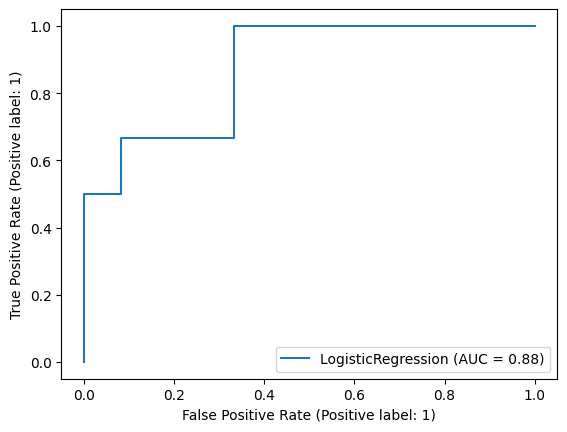

AUC: 0.858 (0.161)


In [17]:
# ROC and AUC from Logistic Regression

# get input and output variables
df = pd.read_csv("https://tinyurl.com/y6r7qjrp")
X = df.values[:, :-1]
y = df.values[:, -1]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=7)

# fit model and get ROC
model = LogisticRegression(penalty=None)
model.fit(X_train, y_train)
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

# get ROC-AUC score
kfold = KFold(n_splits=5, random_state=7, shuffle=True)
model = LogisticRegression(penalty=None)
results = cross_val_score(model, X, y, cv= kfold, scoring= 'roc_auc')
print('AUC: %.3f (%.3f)' % (results.mean(), results.std()))

Class imbalance: when data is not equally represented across every outcome class

Some techniques to combat class imbalance:
- collect more data
- try different models
- duplicate minority samples until classes balanced
- SMOTE lgorithms
- unsupervised anomaly detection models

For predicting more than one category, build separate logistic regressions for each class, and the one that produces the highest probability is the best.

In [18]:
df = pd.read_csv("https://bit.ly/3imidqa")
df.sample(5)

,RED,GREEN,BLUE,LIGHT_OR_DARK_FONT_IND
688,219,112,147,1
900,3,168,158,0
856,255,230,153,1
1127,238,92,66,1
1342,97,97,97,0


In [19]:
# exercise 1

# get input and output variables
X = df.values[:, :-1]
y = df.values[:, -1]

# fit model and get accuracy
kfold = KFold(n_splits= 3)
model = LogisticRegression(penalty= None)
results = cross_val_score(model, X, y, cv= kfold, scoring= 'accuracy')

print('Accuracy Score: Mean = %.3f, StdDev = %.3f' % (results.mean(), results.std()))

Accuracy Score: Mean = 0.999, StdDev = 0.002


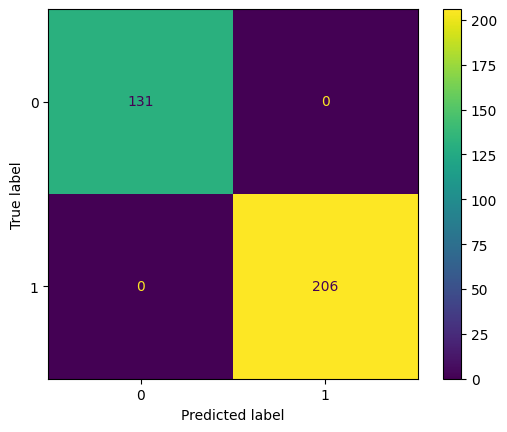

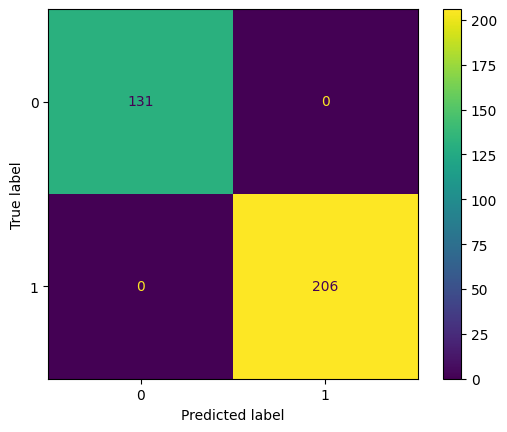

In [20]:
# exercise 2

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

# fit model
model = LogisticRegression(penalty= None)
model.fit(X_train, y_train)

# show confusion matrix from predictions
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test
).plot();

In [21]:
# exercise 3

results = model.predict([
    [138, 186, 104], # probably dark
    [239, 234, 237], # dark
    [87, 135, 44], # probably light?
    [15, 25, 168], # light
    [127, 127, 127], # either way
    [181, 49, 145] # light
])

print(results)

[1 1 0 0 0 0]
